In [30]:
# Importing libs and enabling auto reload on notebooks.
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.special import expit
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def haversine_distance(row):
    # Calculate the Haversine distance between two points in kilometers (using latitude and longitude)
    lon1, lat1, lon2, lat2 = map(math.radians,
                                 [row['latitude'], row['longitude'], row['merchLatitude'], row['merchLongitude']])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    distance = r * c
    return distance

In [32]:
# Reading data training set provided
df = pd.read_csv("trainData.csv")
df.dropna(inplace=True)
df.drop(
    columns=["firstName", "lastName", "street", "zip", "job", "cityPop", "transNum", "city", "state", "creditCardNum",
             "business"], inplace=True)
df['dateOfBirth'] = pd.to_datetime(df['dateOfBirth'])
df['dateOfBirth'] = df['dateOfBirth'].dt.year.astype(float)

column_index = df.columns.get_loc("isFraud")
df.insert(column_index, "amount^2", df["amount"] ** 2)

# Mapping gender to numbers so that we can use them in our features
gender_map = {'M': 2.0, 'F': 1.0}
df['gender'] = df['gender'].map(gender_map)

# Turning the unixTime col into the distance_km col (unix time was wrong in og dataset)
df['unixTime'] = df.apply(haversine_distance, axis=1)
df.rename(columns={'unixTime': 'distance_km'}, inplace=True)

# Mapping all of the cats to a number
cat_map = {
    'misc_net': 10,
    'shopping_net': 9,
    'misc_pos': 8,
    'grocery_pos': 7,
    'entertainment': 6,
    'gas_transport': 5,
    'personal_care': 4,
    'shopping_pos': 3,
    'food_dining': 2,
    'home': 1,
    'kids_pets': 1,
    'grocery_net': 2,
    'health_fitness': 3,
    'travel': 4
}

# Converting transDate to give the date in unix time and then normalize the data
df['transDate'] = pd.to_datetime(df['transDate'], format='%Y-%m-%d %H:%M')
df['transDate'] = df['transDate'].apply(lambda x: datetime.timestamp(x))
df['transDate'] = df['transDate'] / 1000000000

# Map the categories to their numerical values
df['category'] = df['category'].map(cat_map)

# Droping the columns we used since we dont need them anymore
df.drop(columns=['latitude', 'longitude', 'merchLatitude', 'merchLongitude'], inplace=True)

# Ensuring all data types are float64
df = df.astype(float)

# Converting dataframe to csv
df.to_csv("cleanedDataTrain.csv", index=False)

# Write dataFrame to a .txt file
with open('cleanedDataTrain.txt', 'w') as f:
    for index, row in df.iterrows():
        f.write(
            f"{row['transDate']},{row['category']},{row['amount']},{row['gender']},{row['dateOfBirth']},{row['distance_km']},{row['amount^2']},{row['isFraud']}\n")


C:\Users\justi\AppData\Local\Temp\ipykernel_25224\3967632704.py:2: DtypeWarning: Columns (0,2,3,5,6,7,8,9,10,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("trainData.csv")


In [33]:
# Loading data in numpy
def load_data(filename, testing):
    data = np.loadtxt(filename, delimiter=',', skiprows=1)
    if testing:
        X = data[:, :-1]
        y = data[:, -1]
        return X, y
    X = data[:, :]

    return X

In [34]:
# Getting the features and the output var
X_train, y_train = load_data("cleanedDataTrain.txt", True)

In [35]:
def sigmoid(z):
    # print("test3")
    #  if isinstance(z, int) or isinstance(z, float):
    #      return logistic_function(z)
    # 
    #  return logistic_function(z)

    #if isinstance(z, int) or isinstance(z, float):
    # return 1 / (1 + np.exp(-z))

    #return 1 / (1 + np.exp(-z))

    # def sigmoid(z):

    # This equation still is correct for sigmoid however helps us avoid overflow errors
    return 0.5 * (1 + np.tanh(0.5 * z))


In [36]:
def compute_cost(X, y, w, b, *argv):
    m, n = X.shape

    total_cost = 0

    for i in range(m):
        zwb = np.dot(w, X[i]) + b
        fwb = sigmoid(zwb)

        # Clip the values of fwb to avoid log(0) or log(1) issues
        fwb = np.clip(fwb, 1e-15, 1 - 1e-15)

        loss = (-y[i] * np.log(fwb)) - ((1 - y[i]) * np.log(1 - fwb))
        total_cost += loss

    total_cost = total_cost / m

    return total_cost


In [37]:
# Computing gradient
def compute_gradient(X, y, w, b, *argv):
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        z_wb = np.dot(X[i], w) + b
        f_wb = sigmoid(z_wb)

        dj_db += f_wb - y[i]

        dj_dw += (f_wb - y[i]) * X[i]

    dj_dw /= m
    dj_db /= m

    return dj_db, dj_dw

In [51]:
# Gradient Descent
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    #  print("test6")
    m, n = X.shape

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # Save cost J at each iteration
        if i < 100000:  # prevent resource exhaustion 
            cost = cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0 or i == (num_iters - 1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.5f}   ")

    return w_in, b_in, J_history#, w_history

In [52]:
# Predict
def predict(X, w, b):
    m, n = X.shape

    p = np.zeros(m)
    for i in range(m):
        zwb = np.dot(w, X[i]) + b
        zwb = zwb / 30780000  # Divided by sample mean (could improve this :D)
        fwb = sigmoid(zwb)
        p[i] = fwb <= 0.40

    # Last data value not working correctly just appending default value 0 (only needed for final dataset)
    p = np.append(p, 0)

    return p

In [40]:
# Cost compute
def compute_cost_reg(X, y, w, b, lambda_=1):
    #print("test8")
    m, n = X.shape
    cost_without_reg = compute_cost(X, y, w, b)
    reg_cost = 0

    zwb = np.dot(X, w) + b
    fwb = sigmoid(zwb)

    reg_cost = np.sum(w ** 2) * lambda_ / (2 * m)

    total_cost = cost_without_reg + reg_cost

    return total_cost

In [41]:
# Compute Gradient
def compute_gradient_reg(X, y, w, b, lambda_=1):
    # print("test9")
    m, n = X.shape

    dj_db, dj_dw = compute_gradient(X, y, w, b)

    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_ / m) * w[j]

    return dj_db, dj_dw

In [42]:
# Testing (was trying to find correct lambda_ and alpha values
np.random.seed(1)
init_w = np.random.rand(X_train.shape[1]) - 0.5
init_b = 1.0

lambda_ = 0.01  # 0.01

# Some gradient descent settings
iterations = 1000
alpha = 0.01  # 0.01
w, b, J_history, w_history = gradient_descent(X_train, y_train, init_w, init_b,
                                              compute_cost_reg, compute_gradient_reg,
                                              alpha, iterations, lambda_)

Iteration    0: Cost 31.27044   
Iteration  100: Cost  0.25402   
Iteration  200: Cost  2.21626   
Iteration  300: Cost  0.25474   
Iteration  400: Cost  0.25438   
Iteration  500: Cost  0.25427   
Iteration  600: Cost  0.25532   
Iteration  700: Cost  0.25486   
Iteration  800: Cost  0.25468   
Iteration  900: Cost  3.37254   
Iteration  999: Cost  0.25580   


In [43]:
p = predict(X_train, w, b)
print(f"Train Accuracy: {np.mean(p == y_train) * 100}")

Train Accuracy: 97.46508929111599


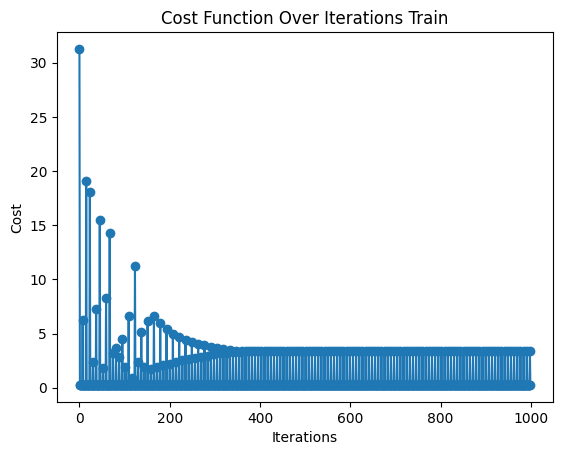

In [47]:
# Ploting our cost function (looks very wrong :/)
def plot_cost_over_iterations(J_history):
    plt.plot(range(len(J_history)), J_history, marker='o', linestyle='-')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost Function Over Iterations Train')
    plt.show()


# Assuming you have already called gradient_descent and obtained J_history
plot_cost_over_iterations(J_history)


In [ ]:
# Using a class and my own model because we can auto run iters to find the best lambda and alhpa vals
class GradientDescentWrapper(BaseEstimator):
    def __init__(self, alpha, lambda_, num_iters):
        self.alpha = alpha
        self.lambda_ = lambda_
        self.num_iters = num_iters

    def fit(self, X, y):
        self.w_, self.b_, self.J_history_ = gradient_descent(X, y, init_w, init_b, compute_cost_reg,
                                                             compute_gradient_reg, self.alpha, self.num_iters,
                                                             self.lambda_)
        return self


# Create an instance of your wrapper class
your_model = GradientDescentWrapper(alpha=0.01, lambda_=0.01, num_iters=20)  # 1000


In [46]:
param_grid = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5],  # Range of values for alpha
    'lambda_': [0.001, 0.01, 0.1, 0.5, 1.0]  # Range of values for lambda
}

# cross-validation
grid_search = GridSearchCV(estimator=your_model, param_grid=param_grid, cv=3,  #5
                           scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Iteration    0: Cost 23.65287   
Iteration    2: Cost  0.19832   
Iteration    4: Cost  0.19832   
Iteration    6: Cost  0.19832   
Iteration    8: Cost  0.76456   
Iteration   10: Cost  0.19832   
Iteration   12: Cost  0.19832   
Iteration   14: Cost  0.19832   
Iteration   16: Cost  0.19832   
Iteration   18: Cost  0.19832   
Iteration   19: Cost  0.19832   
[CV] END .........................alpha=0.001, lambda_=0.001; total time=  25.9s
Iteration    0: Cost 24.07937   
Iteration    2: Cost  0.25901   
Iteration    4: Cost  0.25901   
Iteration    6: Cost  0.25901   
Iteration    8: Cost 20.07914   
Iteration   10: Cost  0.25901   
Iteration   12: Cost  0.25901   
Iteration   14: Cost  0.25901   
Iteration   16: Cost 17.56178   
Iteration   18: Cost  0.25901   
Iteration   19: Cost  0.25901   
[CV] END .........................alpha=0.001, lambda_=0.001; total time=  25.9s
Iteration    0: Cost 24.32191   
Iteration    2: Co

KeyboardInterrupt: 

In [48]:
# Opening up the actual test dataset (renamed)
# doing same thing as df1 (see comments there)
df2 = pd.read_csv("team_9_og.csv")
df2.dropna(inplace=True)
df2.drop(
    columns=["firstName", "lastName", "street", "zip", "job", "cityPop", "transNum", "city", "state", "creditCardNum",
             "business"], inplace=True)
df2['dateOfBirth'] = pd.to_datetime(df['dateOfBirth'])
df2['dateOfBirth'] = df2['dateOfBirth'].dt.year.astype(float)

df2["amount^2"] = df["amount"] ** 2

gender_map = {'M': 2.0, 'F': 1.0}
df2['gender'] = df2['gender'].map(gender_map)

df2['unixTime'] = df2.apply(haversine_distance, axis=1)
df2.rename(columns={'unixTime': 'distance_km'}, inplace=True)

cat_map = {
    'misc_net': 10,
    'shopping_net': 9,
    'misc_pos': 8,
    'grocery_pos': 7,
    'entertainment': 6,
    'gas_transport': 5,
    'personal_care': 4,
    'shopping_pos': 3,
    'food_dining': 2,
    'home': 1,
    'kids_pets': 1,
    'grocery_net': 2,
    'health_fitness': 3,
    'travel': 4
}

df2['transDate'] = pd.to_datetime(df2['transDate'], format='%Y-%m-%d %H:%M')
df2['transDate'] = df2['transDate'].apply(lambda x: datetime.timestamp(x))
df2['transDate'] = df2['transDate'] / 1000000000

df2['category'] = df2['category'].map(cat_map)

df2.drop(columns=['latitude', 'longitude', 'merchLatitude', 'merchLongitude'], inplace=True)

df2 = df2.astype(float)

# Sending cleaned df to a csv file
df2.to_csv("team_9_cleaned.csv", index=False)

# Write df to a .txt file
with open('team_9.txt', 'w') as f:
    for index, row in df2.iterrows():
        f.write(
            f"{row['transDate']},{row['category']},{row['amount']},{row['gender']},{row['dateOfBirth']},{row['distance_km']},{row['amount^2']}\n")

#df2.head

In [53]:
# Loading data test file & getting the np array of the predictions
X_test = load_data("team_9.txt", False)
ans = predict(X_test, w, b)



In [54]:
# New df that copies the original data and adds a isFraud col with values returned.
df3 = pd.read_csv("team_9_og.csv")
df3["isFraud"] = ans
df3.to_csv("team_9.csv", index=False)